# ENHANCING RETAIL PRICE PREDICTION : A COMPARATIVE STUDY OF MACHINE LEARNING AND DEEP LEARNING MODELS

### Stage 1 - Setup, Installations and Functions

In [6]:
#### INSTALL AND IMPORT MODULES ###
#pip install torch torchvision torchaudio
#pip install -U kaleido #for saving image
#pip install pandas 
#pip install numpy 
#pip install nltk 
#pip install matplotlib 
#pip install seaborn 
#pip install plotly 
#pip install scikit-learn torch 
#pip install xgboost
#python -m nltk.downloader stopwords"
import pandas as pd
import numpy as np
import re
import os
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutipatkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
### IGNORE WARNINGS ###
warnings.filterwarnings("ignore")

In [8]:
# Download NLTK resources (if not already downloaded)
stop_nltk = stopwords.words('english')
stop_sklearn = text.ENGLISH_STOP_WORDS

# Initialize WordNet lemmatizer and porter stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [9]:
### LOAD INPUT FILES ###
data_file = "All_Data_Tesco.csv"
df = pd.read_csv(data_file)

In [10]:
### CREATE OUTPUT AND TEMPORARY FOLDERS ###
path = os.getcwd() #get current directory
output_folder = os.path.join(path, "output")
if os.path.exists(output_folder) == False:
    os.mkdir(output_folder)
temporary_folder = os.path.join(path, "temporary")
if os.path.exists(temporary_folder) == False:
    os.mkdir(temporary_folder)

In [11]:
### FUNCTIONS ###
def get_exact_units(x , y):
    units = re.compile(r'\d+\s*'+y+'[x]?')
    op = units.findall(x)
    if len(op) == 0:
        if y == "kg":
            units = re.compile(r'\d+\s*(?:\w+\s*)*pk|\d+\s*g[x]?')
            op = units.findall(x)
        elif y == "l":
            units = re.compile(r'\d+\s*ml[x]?')
            op = units.findall(x)
        else:
            units = re.compile(r'\d+\s*(?:\w+\s*)*pack|\d+\s*(?:\w+\s*)*pk|\d+\s*(?:\w+\s*)*roll|\d+\s*(?:\w+\s*)*match|\d+\s*(?:\w+\s*)*bud|\d+\s*(?:\w+\s*)*box|\d+\s*(?:\w+\s*)*sheet|\d+\s*(?:\w+\s*)*s|\bx\d+\b|\bbags\s+\d+\b[x]?')
            op = units.findall(x)
    try:
        return op[0]
    except:
        return "0 unit"
    
    
def get_correct_values(x, y, z):
        if (x == "kg") & (y == "g"):
            z = z*1000
        elif (x == "g") & (y == "kg"):
            z = z/1000
        elif (x == "l") & (y == "ml"):
            z = z*1000
        elif (x == "l") & (y == "ml"):
                z = z/1000
        return z

### Stage 2 - Understanding Data and Pre-processing Data

In [12]:
### DATA UNDERSTANDING ###
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753502 entries, 0 to 753501
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   supermarket       753502 non-null  object 
 1   prices_(¬£)       753502 non-null  float64
 2   prices_unit_(¬£)  753501 non-null  float64
 3   unit              753501 non-null  object 
 4   names             753502 non-null  object 
 5   date              753502 non-null  int64  
 6   category          753502 non-null  object 
 7   own_brand         753502 non-null  bool   
dtypes: bool(1), float64(2), int64(1), object(4)
memory usage: 41.0+ MB
None


In [13]:
### PRE-PROCESSING DATA ###
df.drop_duplicates(inplace=True) #Drop duplicates

#Lower Case conversion
df["names"] = df["names"].str.lower()
df["unit"] = df["unit"].astype(str).str.lower()

#Remove stop words
df['names'] = df['names'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_nltk)]))
df['names'] = df['names'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_sklearn)]))

#Handle Missing values
df = df[df["prices_(¬£)"] != 0]
df = df[df["names"] != ""]
df["category"] = df["category"].apply(lambda x: "other" if x == "" else x)
df["supermarket"] = df["supermarket"].fillna(method='ffill')
df["own_brand"] = df["own_brand"].fillna("False")

df_1= df[(df["prices_unit_(¬£)"] == 0)]
df_2 = df[(df["prices_unit_(¬£)"] != 0)]

df_1['col_3'] = df_1.apply(lambda x: get_exact_units(x.names, x.unit), axis=1)

df_1['col_4'] = df_1["col_3"].apply(lambda x: re.findall(r'\d+', x)[0])

df_1['col_5'] = df_1["col_3"].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))

df_1['prices_(¬£)'] = df_1.apply(lambda x: get_correct_values(x.unit, x.col_5, x['prices_(¬£)']), axis=1)

df_1['unit'] = df_1["col_3"].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))
df_1['prices_unit_(¬£)'] = df_1['prices_(¬£)'].astype(int)/df_1['col_4'].astype(int) 

df_1 = df_1.drop(["col_3", "col_4", 'col_5'], axis=1) 

df_2_not_unit = df_2[df_2["unit"] != "unit"] 
df_2_unit = df_2[df_2["unit"] == "unit"]
df_2_unit["names"] = df_2_unit["names"] + " "

df_2_kg = df_2_unit[df_2_unit['names'].str.contains('kg ')]
df_2_unit = df_2_unit[~df_2_unit['names'].str.contains('kg ')] 

df_2_g = df_2_unit[df_2_unit['names'].str.contains('g ')] 

df_3_unit = df_2_unit[~df_2_unit['names'].str.contains('g ')] 

df_2_kg['col_3'] = df_2_kg["names"].apply(lambda x: re.findall("r'\d+\s*(?:\w+\s*)*pk|\d+\s*kg", x)[0])
df_2_kg['unit'] = "kg"
df_2_kg['col_4'] = df_2_kg["col_3"].apply(lambda x: re.findall(r'\d+', x)[0])
df_2_kg['prices_unit_(¬£)'] = df_2_kg['prices_(¬£)'].astype(int)/df_2_kg['col_4'].astype(int)

df_2_kg = df_2_kg.drop(["col_3", "col_4"], axis=1) #1
df_list = [df_1, df_2_not_unit, df_2_unit, df_2_kg]
df_filtered = pd.concat(df_list, sort=False)

df_filtered["supermarket"] = df_filtered["supermarket"].str.lower()

#remove name of supermarket from names
df_filtered["names"] = df_filtered.apply(lambda row: row.names.replace(row.supermarket, "").strip(), axis=1)
#remove words with length less than 3 from names
df_filtered["names"] = df_filtered['names'].str.replace(r'\d+', '').str.replace(r'\b\w{1,2}\b', '').str.replace(r"[^\w\s]", '')
df_filtered["names"] = df_filtered['names'] + " "
#convert plurals to singular for removing unit from names column
df_filtered["names"]  = df_filtered["names"].apply(lambda x: " ".join([lemmatizer.lemmatize(word, pos='n') for word in x.split(" ")]))
#remove unit if present in names column
df_filtered["names"] = df_filtered.apply(lambda row: row.names.replace(row.unit+" ", "").strip(), axis=1)  

df_filtered_1 = df_filtered[df_filtered["names"] == ""]

df_filtered_1 = df_filtered_1[df_filtered_1["unit"].str.len() > 1]

df_filtered_2 = df_filtered[df_filtered["names"] != ""]

df_filtered_1["names"]  = df_filtered["unit"]

df_filtered = pd.concat([df_filtered_2, df_filtered_1], sort=False)

#use stemmer to group similar words as same.
df_filtered["names"]  = df_filtered["names"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split(" ")]))
#get unique values and in ascending order
df_filtered[["names", "unit"]] = df_filtered[["names", "unit"]].applymap(lambda x:" ".join(sorted(list(set(x.split())))))
df_filtered[["names", "unit"]] = df_filtered[["names", "unit"]].applymap(lambda x:x.strip())
df_filtered.drop(columns= ["supermarket", "prices_unit_(¬£)"], inplace=True)

#Convert into categorical data
category = pd.Categorical(df_filtered["category"])
own_brand = pd.Categorical(df_filtered["own_brand"])
units = pd.Categorical(df_filtered["unit"])
names = pd.Categorical(df_filtered["names"])

df_filtered["category_2"] = category.codes
df_filtered["own_brand_2"] = own_brand.codes
df_filtered["unit_2"] = units.codes
df_filtered["names_2"] = names.codes

In [14]:
print(df_filtered.head())

     prices_(¬£)          unit                            names      date  \
551         4.20             m             polyest thread white  20240211   
564         1.20            pk          sucralos sweeten tablet  20240211   
565         3.65          pack           hermeseta mini sweeten  20240211   
659         2.60     long roll  luxuri recycl soft tissu toilet  20240211   
962         1.15  pack tablets              pack sweeten tablet  20240211   

          category  own_brand  category_2  own_brand_2  unit_2  names_2  
551      household      False           8            0       9    25058  
564  food_cupboard       True           3            1      15    25397  
565  food_cupboard      False           3            0      13    22803  
659      household       True           8            1       8    23915  
962         drinks       True           2            1      14    24831  


In [15]:
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729668 entries, 551 to 675220
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   prices_(¬£)  729668 non-null  float64
 1   unit         729668 non-null  object 
 2   names        729668 non-null  object 
 3   date         729668 non-null  int64  
 4   category     729668 non-null  object 
 5   own_brand    729668 non-null  bool   
 6   category_2   729668 non-null  int8   
 7   own_brand_2  729668 non-null  int8   
 8   unit_2       729668 non-null  int8   
 9   names_2      729668 non-null  int16  
dtypes: bool(1), float64(1), int16(1), int64(1), int8(3), object(3)
memory usage: 37.6+ MB
None


### Stage 3 - Exploratory Data Analysis

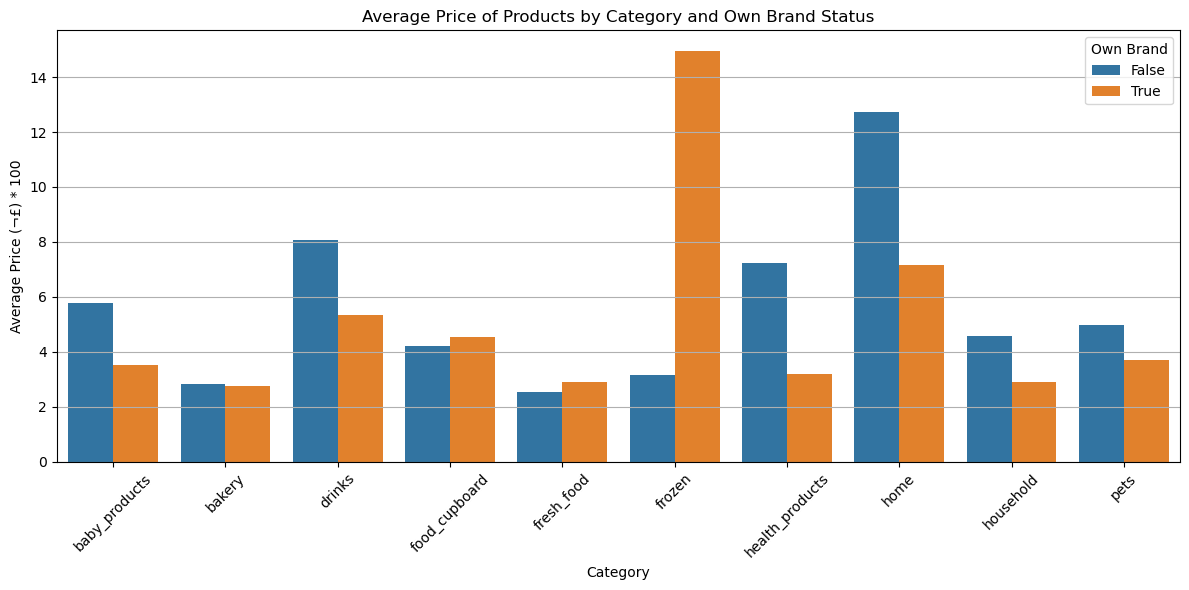

In [16]:
### DATA VISUALISATION ###
# Calculate the average price for each category and own brand status
average_prices = df_filtered.groupby(['category', 'own_brand'])['prices_(¬£)'].mean().reset_index()

# Plot the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_prices, x='category', y='prices_(¬£)', hue='own_brand')
plt.title('Average Price of Products by Category and Own Brand Status')
plt.xlabel('Category')
plt.ylabel('Average Price (¬£) * 100')
plt.xticks(rotation=45)
plt.legend(title='Own Brand', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_folder,'AvgPriceByCategory&OwnBrand.png'))
plt.show()

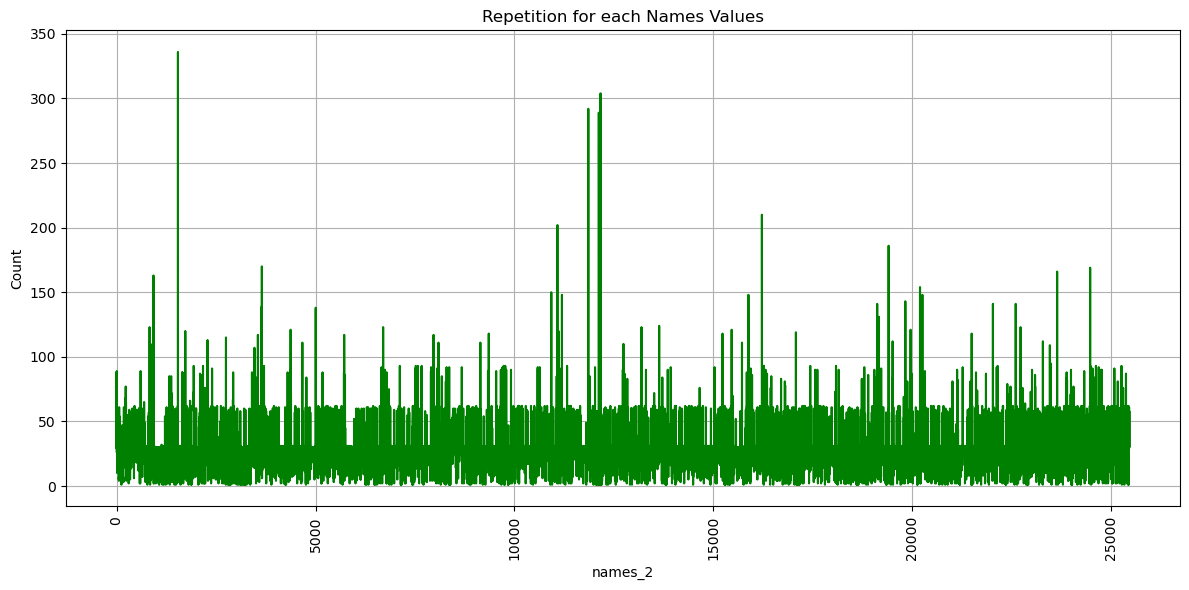

In [17]:
# Count the occurrences of each names_2 value
name_counts = df_filtered['names_2'].value_counts().sort_index()

# Plot the line plot
plt.figure(figsize=(12, 6))
plt.plot(name_counts.index, name_counts.values, linestyle='-', color="green")
plt.title('Repetition for each Names Values')
plt.xlabel('names_2')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_folder,'RepetitionForNamesValues.png'))
plt.show()

In [18]:
pio.renderers.default = 'notebook' #to make Surnburst be visible in jupiter notebook
# Count the occurrences of each category,own_brand and dates combination
df_counts = df_filtered.groupby(['own_brand','category', "date"]).size().reset_index(name='count')

# Create the sunburst chart
fig = px.sunburst(df_counts, path=['own_brand','category', "date"], values='count')
fig.update_layout(title="Sunburst Chart: Distribution of Counts by Own Brand, Category, and Date")
fig.write_image(os.path.join(output_folder,'DistributionOfCategory&OwnBrand&Dates.png'))
fig.show()

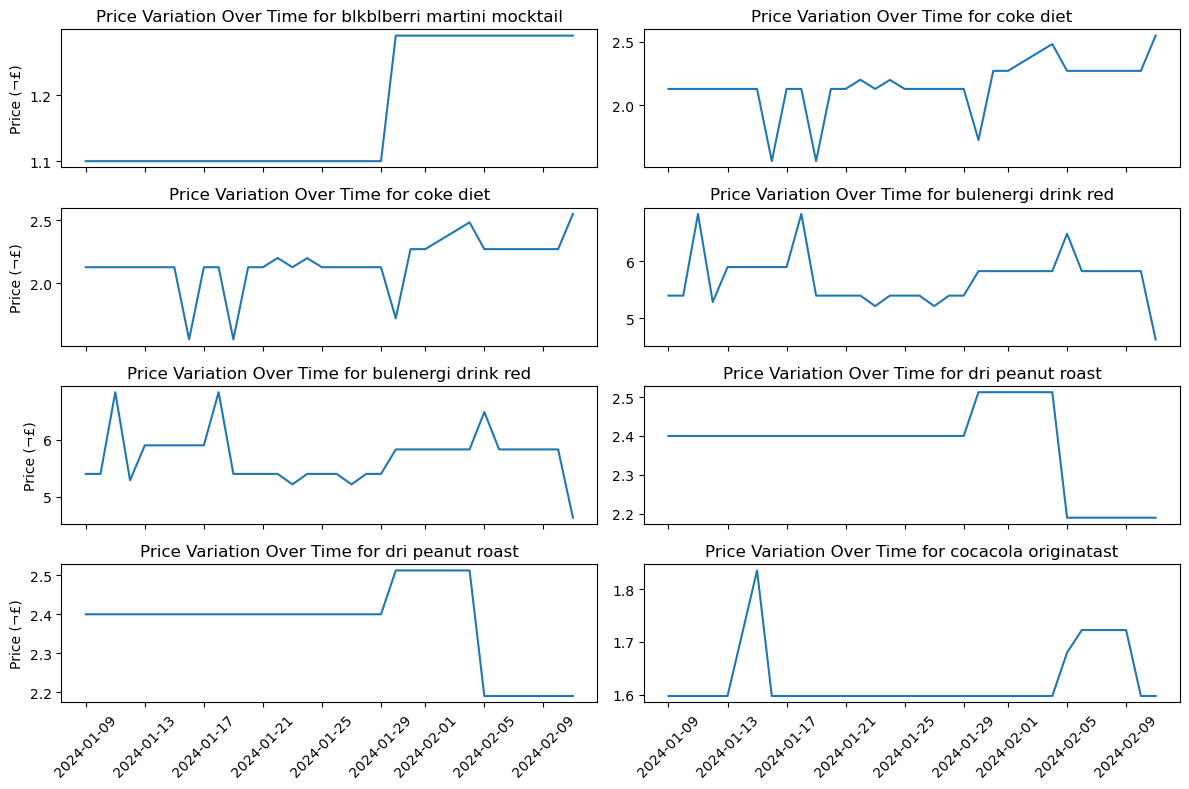

In [15]:
x = df_filtered.groupby(["names", "date", "prices_(¬£)"]).size().sort_values(ascending=False).reset_index()

x["date"] = pd.to_datetime(x["date"], format='%Y%m%d')
z = df_filtered.groupby(["names", "date"])["prices_(¬£)"].nunique().sort_values(ascending=False).reset_index()

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 8), sharex=True)

# Plot price variation over time for each product upto 8 most variable date 
for i in range(4):
    for j in range(2):
        product_name = z["names"].unique()[i+j-1]
        product_df = x[x["names"] == product_name]
        product_df = product_df.groupby(["names", "date"])["prices_(¬£)"].mean().reset_index()
        product_df = product_df.sort_values("date")
        axs[i, j].plot(product_df['date'], product_df['prices_(¬£)'])
        axs[i, 0].set_ylabel('Price (¬£)')
        axs[i, j].set_title(f'Price Variation Over Time for {product_name}')
        axs[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(output_folder,'PriceVariationOverTime.png'))
plt.show()

In [16]:
#get required columns
df_final = df_filtered[['prices_(¬£)','date', 'category_2', 'own_brand_2', 'unit_2', 'names_2']]

<Figure size 640x480 with 0 Axes>

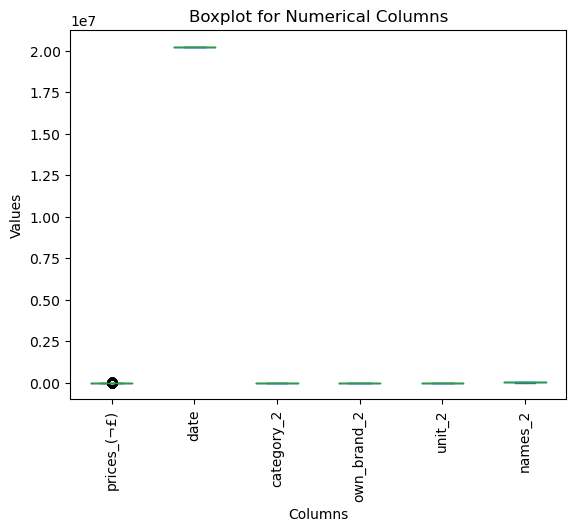

In [17]:
# Plotting boxplot for numerical columns in the DataFrame df_2 with a specified title
plt.figure() 
ax = df_final.plot(kind='box', title='Boxplot for Numerical Columns')
plt.xticks(fontsize=10, rotation=90)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.savefig(os.path.join(output_folder,'BoxplotForNumericalColumns.png'))
plt.show()

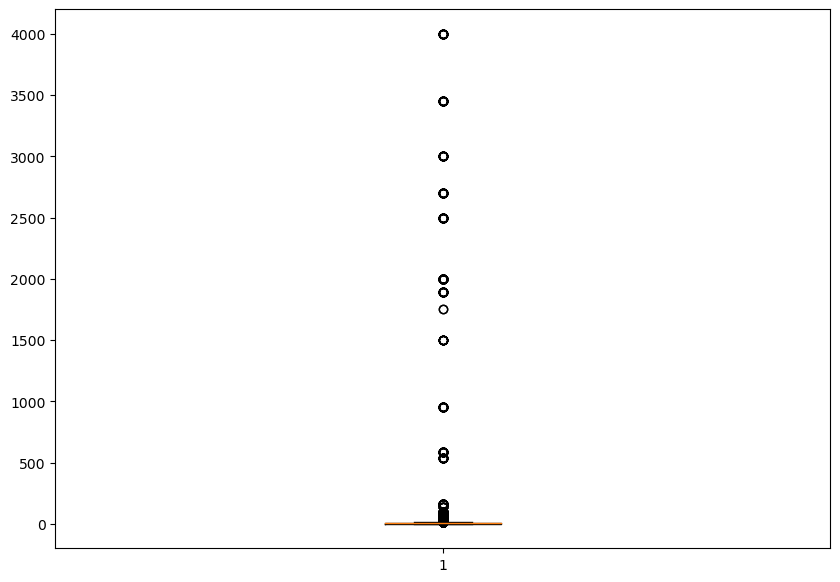

In [18]:
### HANDLING OULIERS ###
#Plotting boxplot for prices as rest values seem okay
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df_final["prices_(¬£)"])
plt.savefig(os.path.join(output_folder,'BoxplotForPricesBeforeOutliersRemoval.png'))
plt.show()

In [19]:
#Dropping outliers
df_final = df_final[df_final["prices_(¬£)"] < 500]

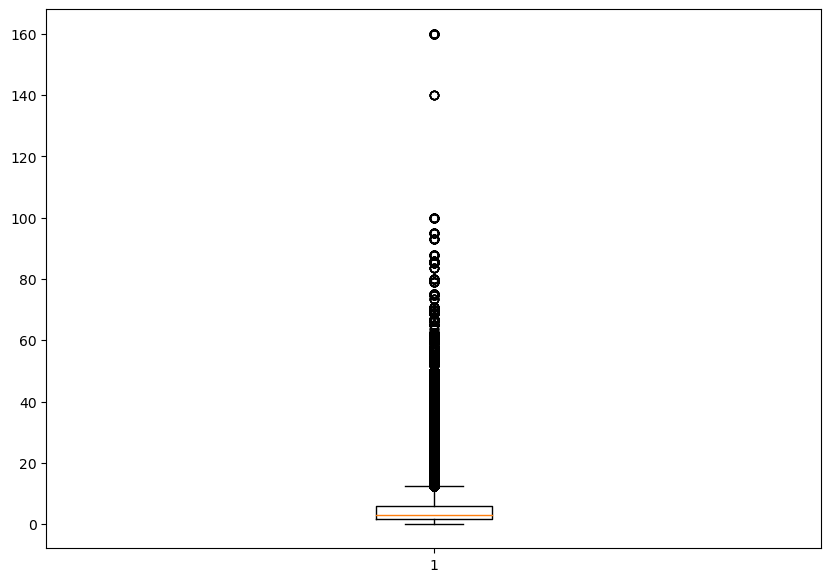

In [20]:
#Plotting boxplot again for prices
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df_final["prices_(¬£)"])
plt.savefig(os.path.join(output_folder,'BoxplotForPricesAfterOutliersRemoval.png'))
plt.show()

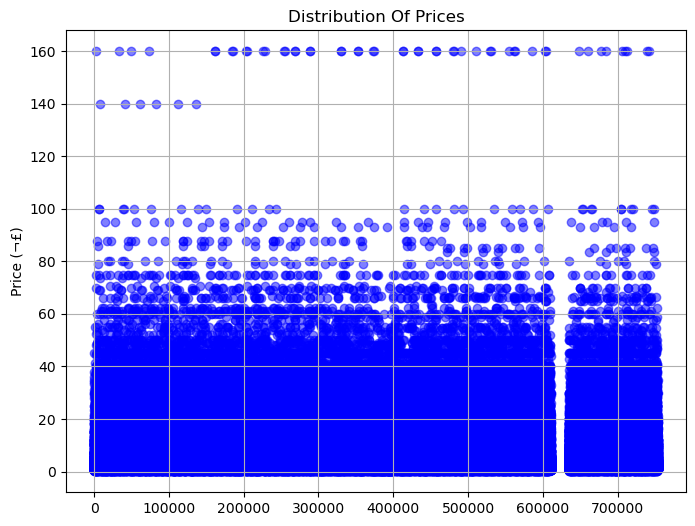

In [21]:
# See Distribution of prices_(¬£) data
plt.figure(figsize=(8, 6))
plt.scatter(df_final.index, df_final['prices_(¬£)'], color='blue', alpha=0.5)
plt.title('Distribution Of Prices')
plt.ylabel('Price (¬£)')
plt.grid(True)
plt.savefig(os.path.join(output_folder,'DistributionOfPrices.png'))
plt.show()

In [22]:
### FEATURE SELECTION AND EXTRACTION ###
#Getting date column seperated as day, month, year, week_day
df_final['year'] = pd.to_datetime(df_final['date'], format='%Y%m%d').dt.year
df_final['month'] = pd.to_datetime(df_final['date'], format='%Y%m%d').dt.month
df_final['day_of_month'] = pd.to_datetime(df_final['date'], format='%Y%m%d').dt.day
df_final['day_of_week'] = pd.to_datetime(df_final['date'], format='%Y%m%d').dt.dayofweek 

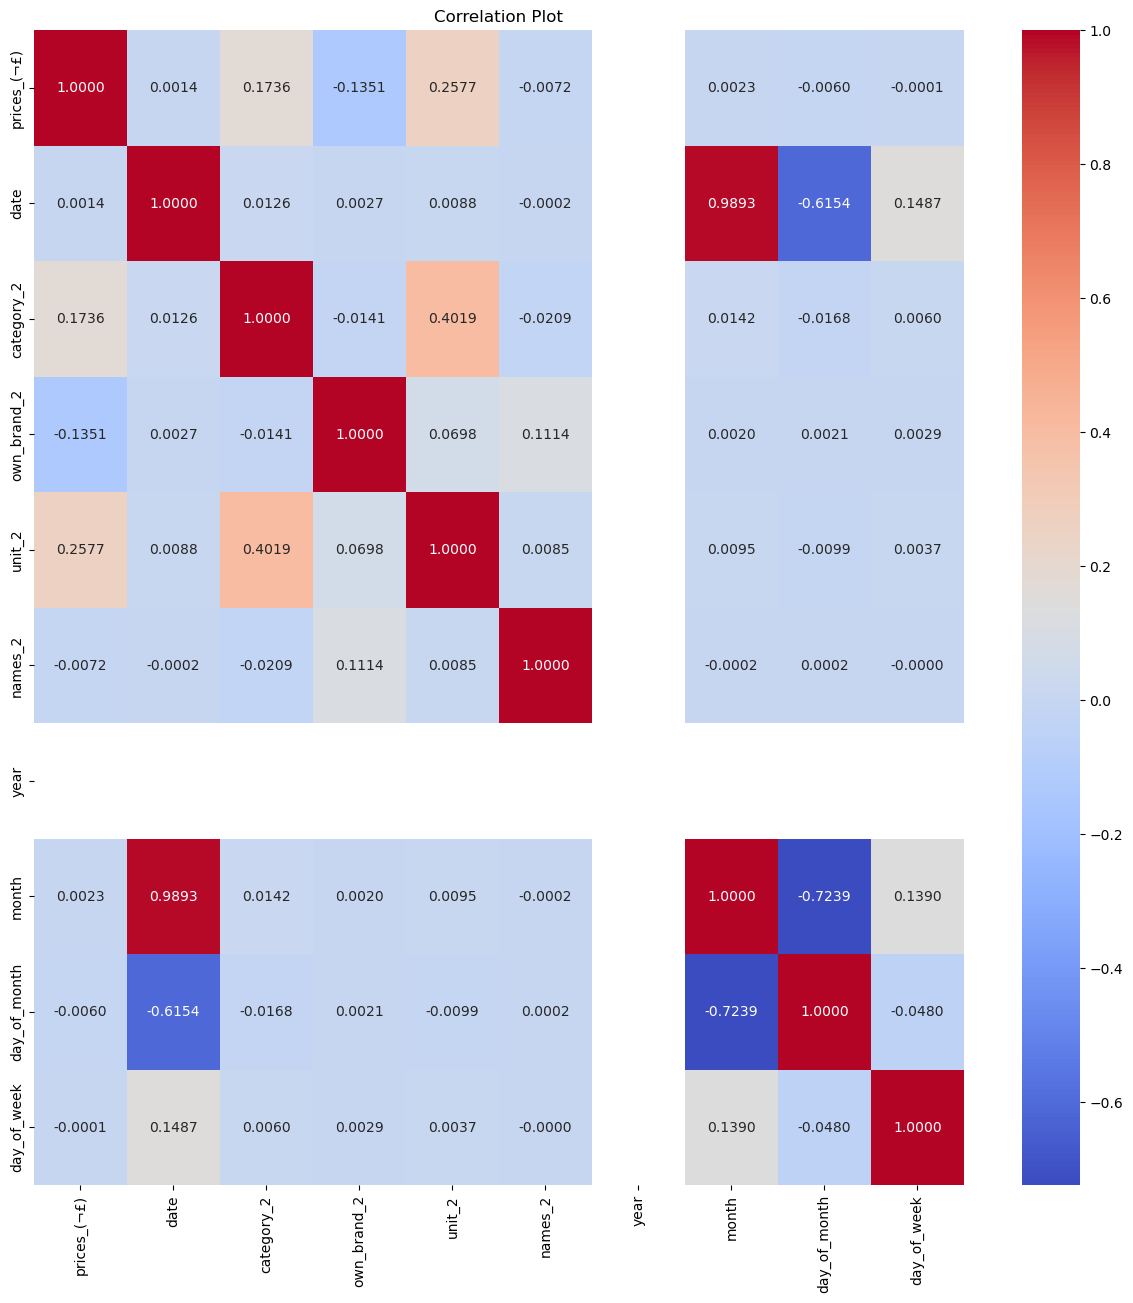

In [23]:
correlation_matrix = df_final.corr()
# Create correlation plot
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Plot')
plt.savefig(os.path.join(output_folder,'CorrealationPlotBeforeRemovingColumns.png'))
plt.show()

In [24]:
df_final_2 = df_final.drop(columns=["date", "year", "day_of_week"])

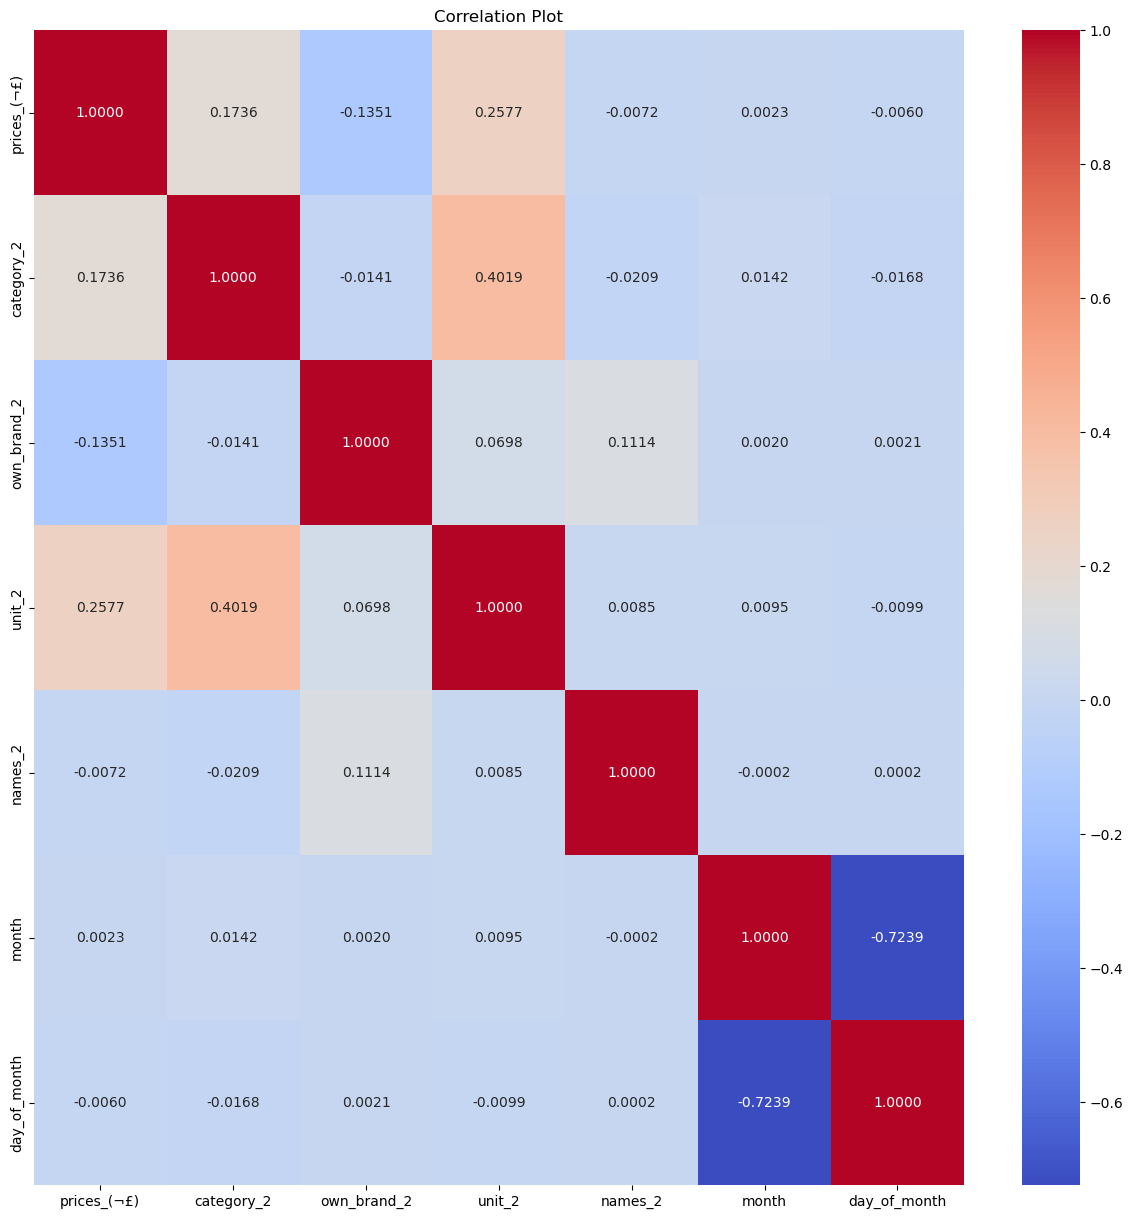

In [25]:
correlation_matrix = df_final_2.corr()
# Create correlation plot
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Correlation Plot')
plt.savefig(os.path.join(output_folder,'CorrealationPlotAfterRemovingColumns.png'))
plt.show()

In [26]:
#Dropping duplicate values after dropping columns using correlation matrix
df_final_2 = df_final_2.drop_duplicates()
df_final_2.to_csv(os.path.join(temporary_folder, "final_data_for_ML.csv"), index=False) #data ready for training

### Stage 4 - Split for Evaluation and Training and testing on Models

In [27]:
# Standardization
standard_scaler = StandardScaler()
df_final_2[['category_2', 'own_brand_2', 'unit_2', 'names_2', 'month', 'day_of_month']] = standard_scaler.fit_transform(df_final_2[['category_2', 'own_brand_2', 'unit_2', 'names_2', 'month', 'day_of_month']])

### SPLIT DATA ###
#Split data into input and target values
X = df_final_2.drop(['prices_(¬£)'], axis=1)
y = df_final_2['prices_(¬£)']

# Splitting the data into training and validation sets
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, test_size=0.2, random_state=42)#random split

bin_count = 5
bin_numbers = pd.qcut(x=y_train_test, q=bin_count, labels=False, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=42, stratify=bin_numbers) #stratified split

X_train_test.to_csv(os.path.join(temporary_folder, "X_train_test.csv"), index=False)
y_train_test.to_csv(os.path.join(temporary_folder, "y_train_test.csv"), index=False)
X_train.to_csv(os.path.join(temporary_folder, "X_train.csv"), index=False)
X_val.to_csv(os.path.join(temporary_folder, "X_val.csv"), index=False)
y_train.to_csv(os.path.join(temporary_folder, "y_train.csv"), index=False)
y_val.to_csv(os.path.join(temporary_folder, "y_val.csv"), index=False)

y_pred_df = pd.DataFrame()

In [28]:
### TRAIN TEST ON SOME OF BEST MODELS ###
### Model 1 ###
print("KNN")
# Model training
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Model evaluation
y_pred_train = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Training RMSE:", train_rmse)

y_pred_test = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print("Testing RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred_test)
print("R2 score:", r2)
print("________________")

y_pred_df["Knn"] = y_pred_test

### model 2 ##
# Model training
print("Decision Tree")
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred_train = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Training RMSE:", train_rmse)

y_pred_test = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print("Testing RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred_test)
print("R2 score:", r2)
print("________________")

y_pred_df["Decision_Tree"] = y_pred_test

## model 3 ##
print("Extra Tree")
model = ExtraTreesRegressor(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

# Model evaluation
y_pred_train = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Training RMSE:", train_rmse)

y_pred_test = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print("Testing RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred_test)
print("R2 score:", r2)
print("________________")

y_pred_df["Extra_Tree"] = y_pred_test

### model 4 ###
print("XGBoost")

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse'  # Evaluation metric
}
# Train the model
model = xgb.train(params, dtrain)

# Make predictions
y_pred_train = model.predict(dtrain)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Training RMSE:", train_rmse)

y_pred_test = model.predict(dtest)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print("Testing RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred_test)
print("R2 score:", r2)
print("________________")

y_pred_df["XGBoost"] = y_pred_test

### model 5 ###
print("Gradient Boost")
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Training RMSE:", train_rmse)

y_pred_test = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print("Testing RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred_test)
print("R2 score:", r2)
print("________________")

y_pred_df["Gradient_Boost"] = y_pred_test

###model 6 ###
print("Random Forest")
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

# Model evaluation
y_pred_train = model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print("Training RMSE:", train_rmse)

y_pred_test = model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print("Testing RMSE:", test_rmse)

r2 = r2_score(y_test, y_pred_test)
print("R2 score:", r2)

y_pred_df["Random_Forest"] = y_pred_test

y_pred_df.to_csv(os.path.join(temporary_folder, "y_pred_1.csv"), index=False)

KNN
Training RMSE: 4.56737571114985
Testing RMSE: 5.6935078492999
R2 score: 0.2882940955416682
________________
Decision Tree
Training RMSE: 0.8523792993952896
Testing RMSE: 1.9205408681479443
R2 score: 0.9190181250337626
________________
Extra Tree
Training RMSE: 0.8523804390680335
Testing RMSE: 2.209291012127044
R2 score: 0.8928365780926174
________________
XGBoost
Training RMSE: 5.67812410107158
Testing RMSE: 5.684497255436081
R2 score: 0.29054501658220144
________________
Gradient Boost
Training RMSE: 5.752621347678541
Testing RMSE: 5.787883242862998
R2 score: 0.2645041193311909
________________
Random Forest
Training RMSE: 0.9215520422285676
Testing RMSE: 1.6580109032176495
R2 score: 0.9396446898826581


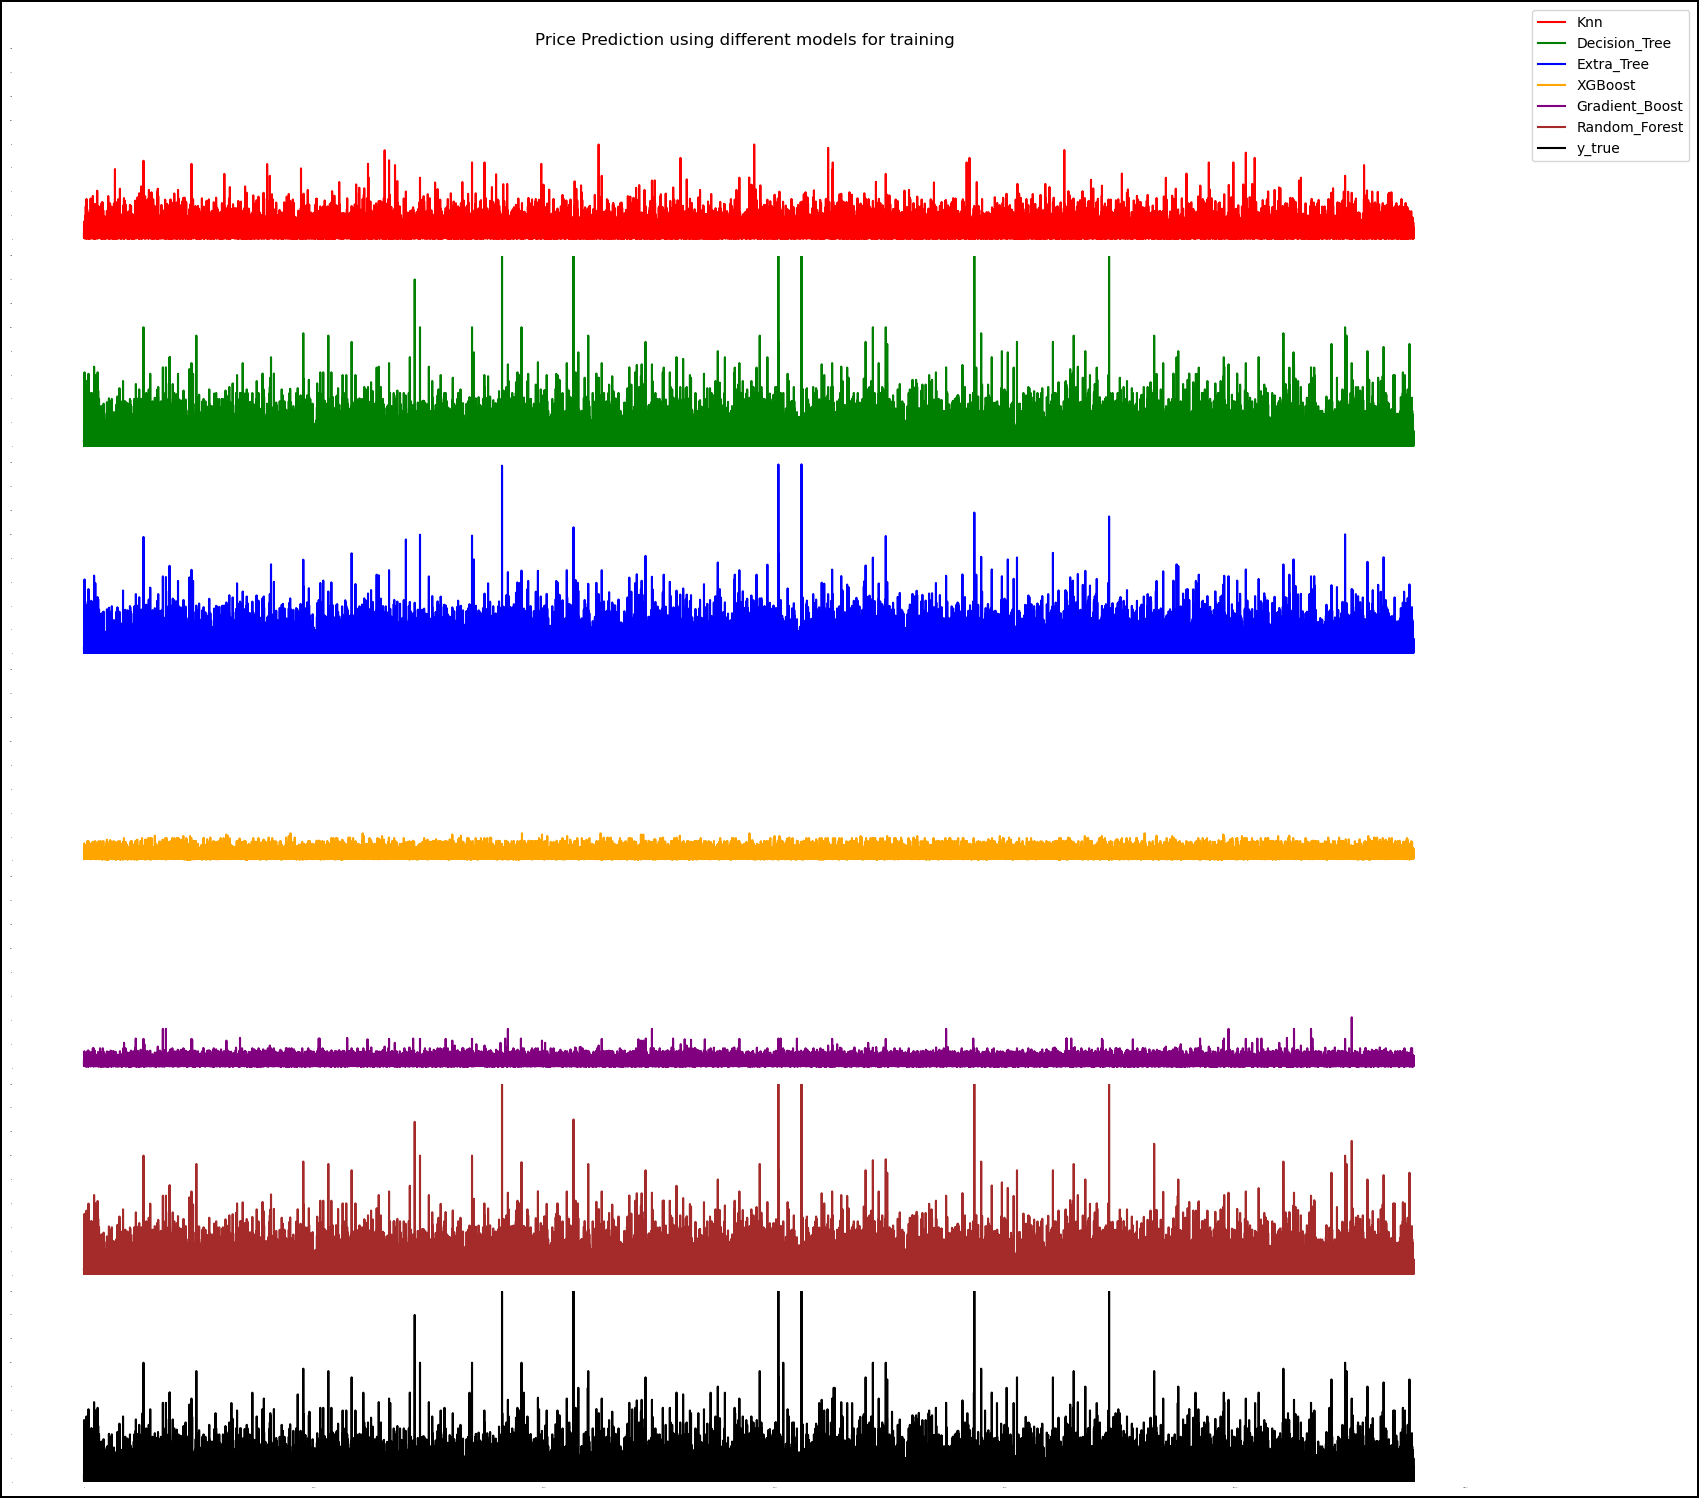

In [29]:
y_test = y_test.reset_index(drop=True)
y_pred_df["y_true"] = y_test

colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'black', "pink"]

# Create subplots
fig, axs = plt.subplots(len(y_pred_df.columns), 1, figsize=(15, 15), sharex=True, sharey=True)
# Initialize lists to collect handles and labels for the legend
handles = []
labels = []
max_value = y_pred_df.max().max()

for i, (column, color) in enumerate(zip(y_pred_df.columns, colors)):
    line, = axs[i].plot(y_pred_df.index, y_pred_df[column], color=color)
    axs[i].tick_params(axis='both', which='both', length=0, labelsize=0)
    axs[i].set_ylim(0, max_value) 
    handles.append(line)
    labels.append(column)

# Remove borders for each subplot
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1))
fig.patch.set_edgecolor('black') #outside border
fig.patch.set_linewidth(1.5)
fig.suptitle("Price Prediction using different models for training")

plt.subplots_adjust(right=0.85) 
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Predicted_values_stage_1.png'))
plt.show()

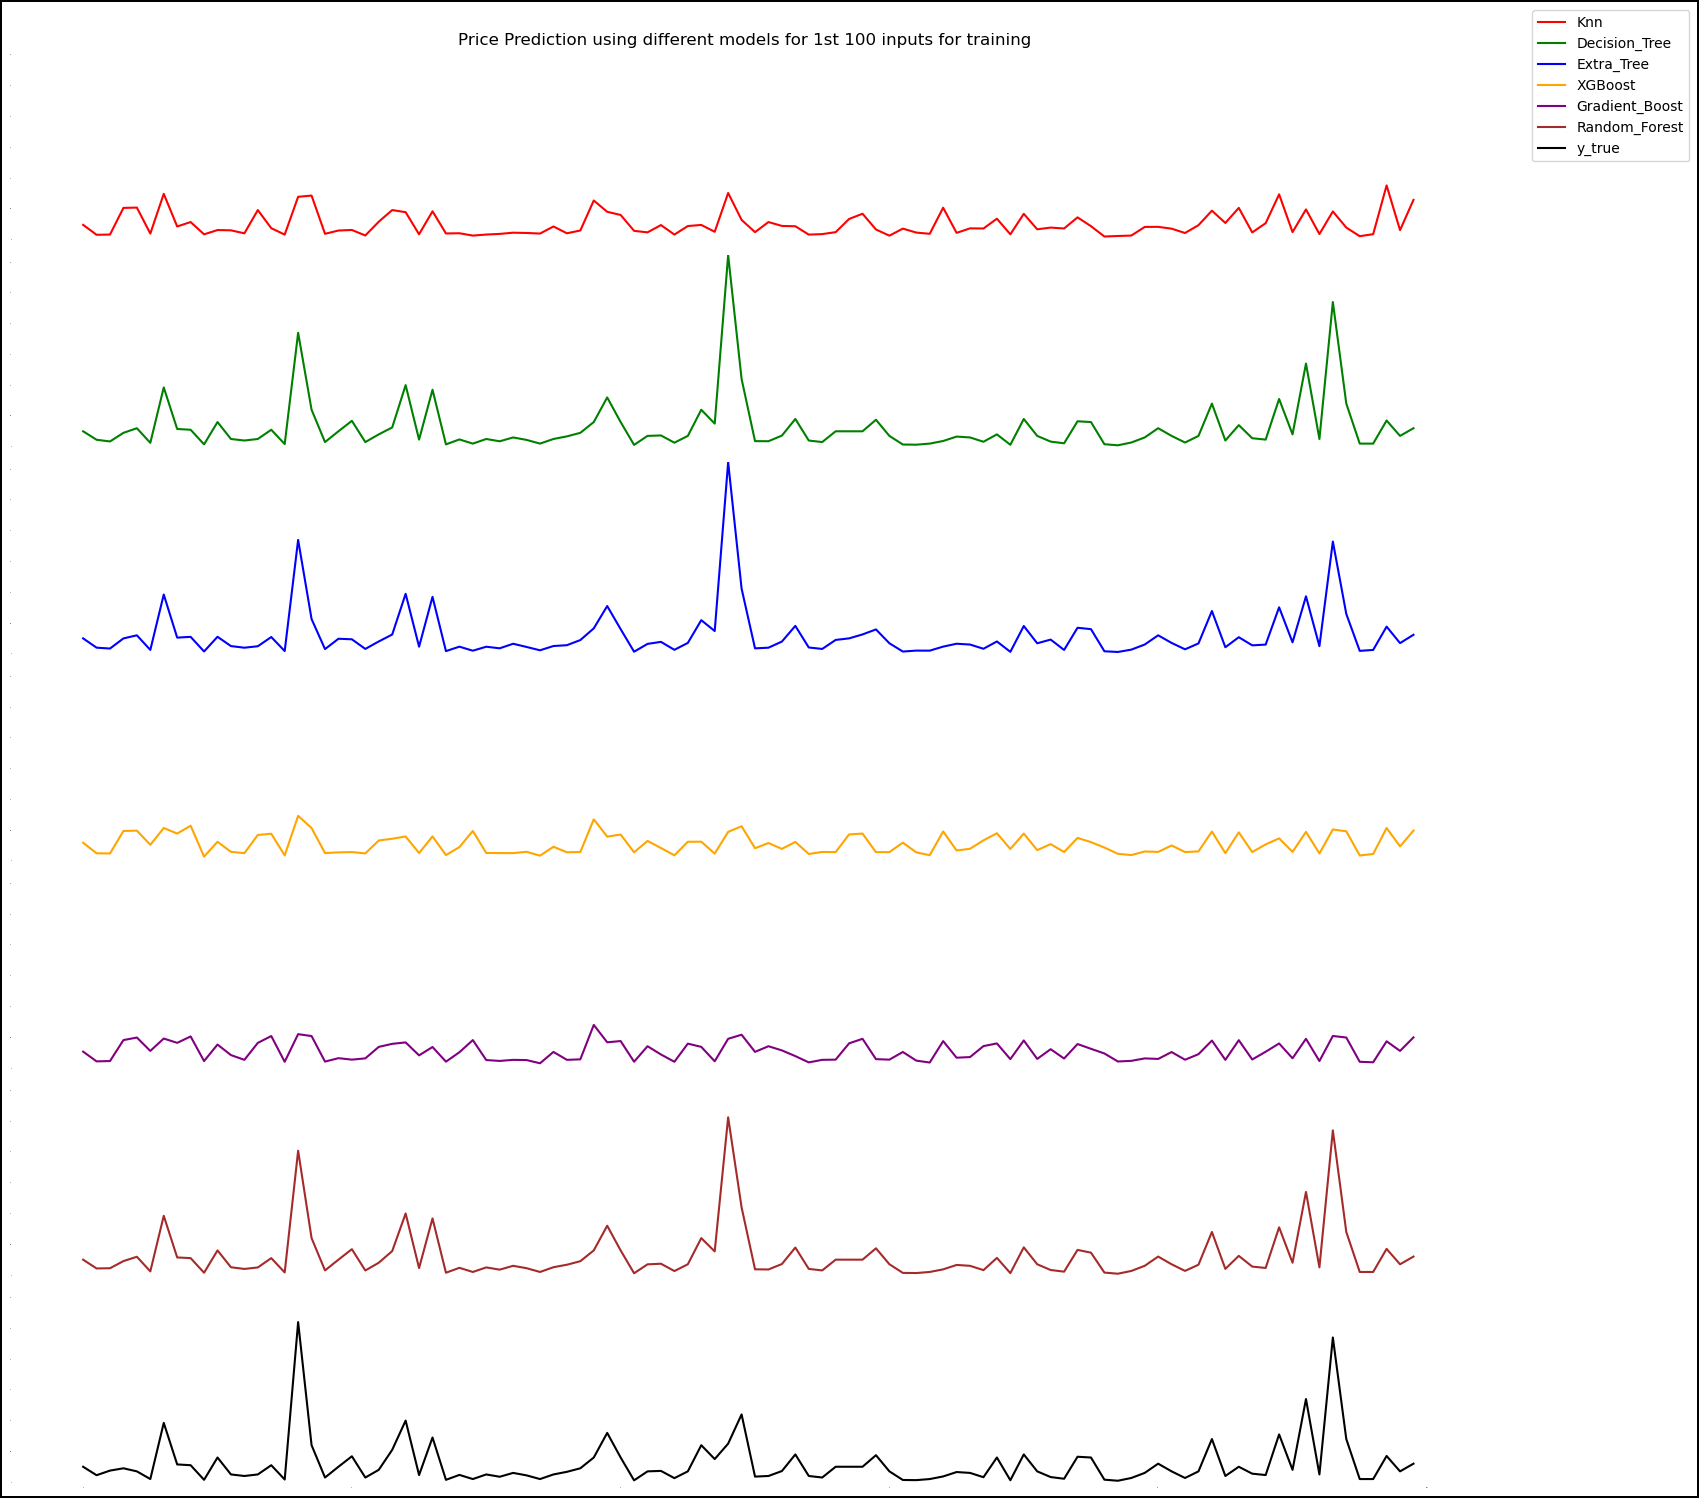

In [30]:
y_pred_df_2 = y_pred_df[:100]
y_test_100 = y_test[:100]
y_test_100 = y_test_100.reset_index(drop=True)
y_pred_df_2["y_true"] = y_test_100

# Create subplots
fig, axs = plt.subplots(len(y_pred_df_2.columns), 1, figsize=(15, 15), sharex=True, sharey=True)
# Initialize lists to collect handles and labels for the legend
handles = []
labels = []

max_value = y_pred_df_2.max().max()
 
for i, (column, color) in enumerate(zip(y_pred_df_2.columns, colors)):
    line, = axs[i].plot(y_pred_df_2.index, y_pred_df_2[column], color=color)
    axs[i].tick_params(axis='both', which='both', length=0, labelsize=0)
    axs[i].set_ylim(0, max_value) 
    handles.append(line)
    labels.append(column)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Create a single legend for all subplots and place it outside the borders
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1.5)
fig.suptitle("Price Prediction using different models for 1st 100 inputs for training")

plt.subplots_adjust(right=0.85) 
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Predicted_values_stage_1_1st_100_inputs.png'))
plt.show()

### Stage 5 - Hyperparameter Tuning, Cross Validation and Evaluation

In [43]:
### DECISION TREE ###
dt = DecisionTreeRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [None, 100, 150, 180, 200],
    'min_samples_split': [14, 15, 16, 17, 18],
    'min_samples_leaf': [2, 3, 4, 5]
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with best hyperparameters on the validation set
best_dt = grid_search.best_estimator_
y_pred_train_dt = best_dt.predict(X_test)
train_rmse = mean_squared_error(y_test, y_pred_train_dt, squared=False)
print("Mean Squared Error for training:", train_rmse)

y_pred_dt = best_dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred_dt, squared=False)
print("Mean Squared Error for evaluation:", mse)

r2 = r2_score(y_test, y_pred_train_dt)
print("R2 score for for training:", r2)

r2 = r2_score(y_val, y_pred_dt)
print("R2 score for for evaluation:", r2)

y_pred_df["Decision_tree_with_tuning"] = y_pred_train_dt
y_pred_df.to_csv(os.path.join(temporary_folder, "y_pred_1.csv"), index=False)

y_pred_hyperparamter_tuned = pd.DataFrame()
y_pred_hyperparamter_tuned["Decision_tree"] = y_pred_dt
y_pred_hyperparamter_tuned.to_csv(os.path.join(temporary_folder, "y_pred_2.csv"), index=False)

Best Hyperparameters: {'max_depth': 200, 'min_samples_leaf': 3, 'min_samples_split': 15}
Mean Squared Error for training: 1.53135009358241
Mean Squared Error for evaluation: 1.576021562360182
R2 score for for training: 0.9485139350505599
R2 score for for evaluation: 0.946312117310225


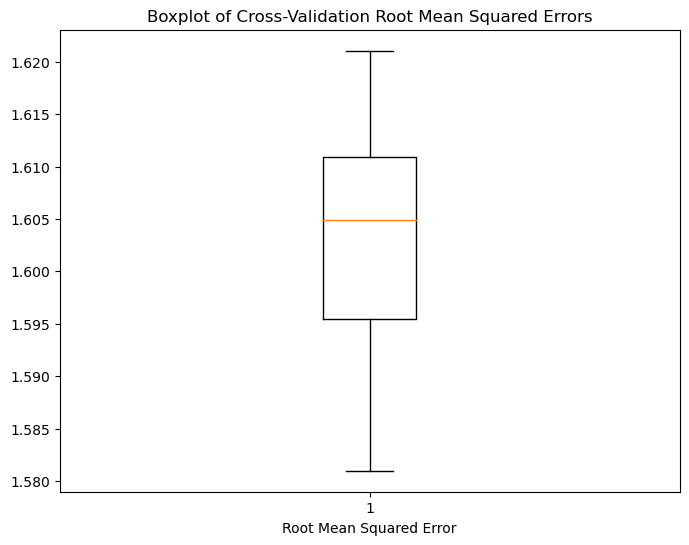

In [44]:
cv_results = grid_search.cv_results_
mse_scores = np.sqrt(-cv_results['mean_test_score'])
plt.figure(figsize=(8, 6))
plt.boxplot(mse_scores)
plt.xlabel('Root Mean Squared Error')
plt.title('Boxplot of Cross-Validation Root Mean Squared Errors')
plt.savefig(os.path.join(output_folder, 'BoxplotCross-ValidationRSMEDecisionTree.png'))
plt.show()

In [35]:
### RANDOM FOREST ###
rf = RandomForestRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [200, 250, 500],
    'max_depth':[None, 100, 150, 180, 200],
    'min_samples_split':[14, 15, 16, 17],
    'min_samples_leaf': [2, 3, 4, 5]   
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with best hyperparameters on the test set
best_rf = grid_search.best_estimator_
y_pred_train_dt = best_rf.predict(X_test)
train_rmse = mean_squared_error(y_test, y_pred_train_dt, squared=False)
print("Mean Squared Error for training:", train_rmse)

y_pred_dt = best_dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred_dt, squared=False)
print("Mean Squared Error for evaluation:", mse)

r2 = r2_score(y_test, y_pred_train_dt)
print("R2 score for for training:", r2)

r2 = r2_score(y_val, y_pred_dt)
print("R2 score for for evaluation:", r2)

y_pred_df["Random_forest_with_tuning"] = y_pred_train_dt
y_pred_df.to_csv(os.path.join(temporary_folder, "y_pred_1.csv"), index=False)

y_pred_hyperparamter_tuned["Random_forest"] = y_pred_dt
y_pred_hyperparamter_tuned.to_csv(os.path.join(temporary_folder, "y_pred_2.csv"), index=False)

Best Hyperparameters: {'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 200}
Mean Squared Error for training: 1.5058189624963516
Mean Squared Error for evaluation: 1.6128934394815584
R2 score for for training: 0.9502164061307217
R2 score for for evaluation: 0.9437706170514711


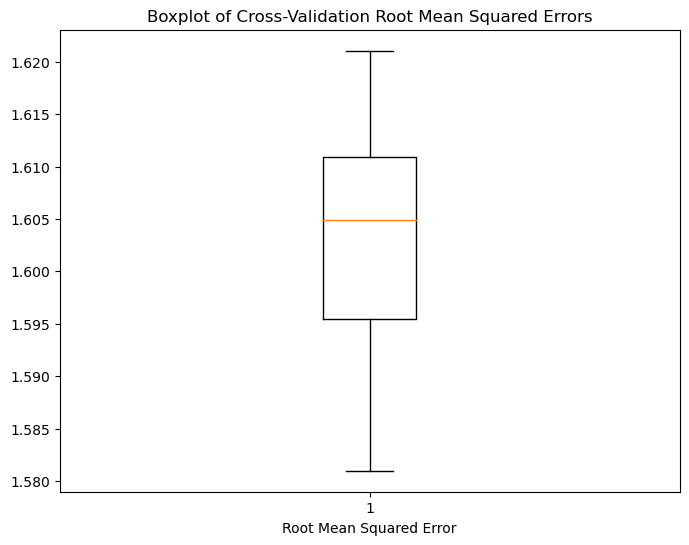

In [45]:
cv_results = grid_search.cv_results_
mse_scores = np.sqrt(-cv_results['mean_test_score'])
plt.figure(figsize=(8, 6))
plt.boxplot(mse_scores)
plt.xlabel('Root Mean Squared Error')
plt.title('Boxplot of Cross-Validation Root Mean Squared Errors')
plt.savefig(os.path.join(output_folder, 'BoxplotCross-ValidationRSMERandomForest.png'))
plt.show()

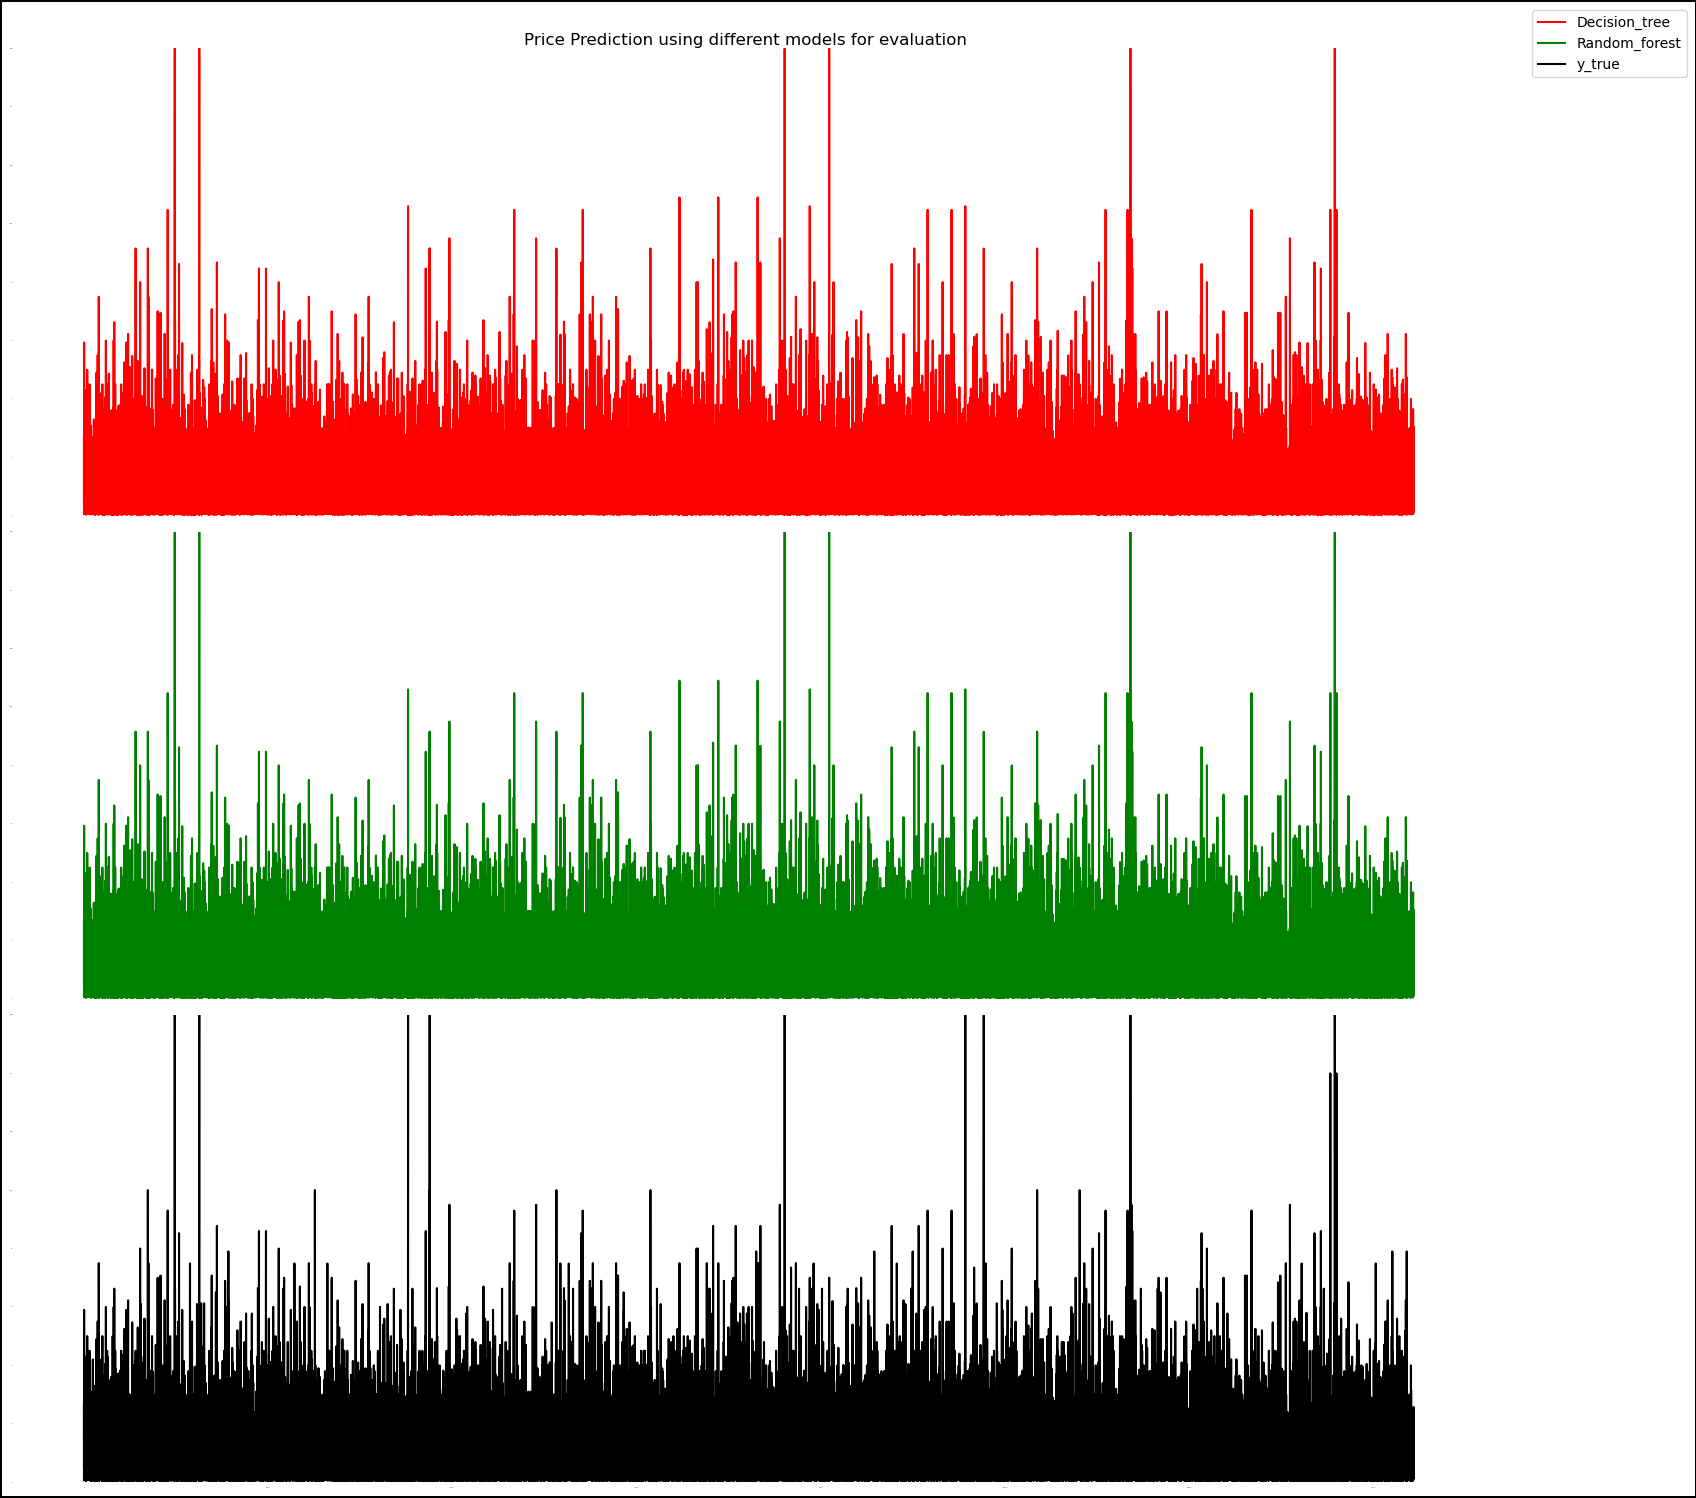

In [38]:
y_val = y_val.reset_index(drop=True)
y_pred_hyperparamter_tuned["y_true"] = y_val

colors = ['red', 'green', "black"]

# Create subplots
fig, axs = plt.subplots(len(y_pred_hyperparamter_tuned.columns), 1, figsize=(15, 15), sharex=True, sharey=True)
# Initialize lists to collect handles and labels for the legend
handles = []
labels = []
max_value = y_pred_hyperparamter_tuned.max().max()

for i, (column, color) in enumerate(zip(y_pred_hyperparamter_tuned.columns, colors)):
    line, = axs[i].plot(y_pred_hyperparamter_tuned.index, y_pred_hyperparamter_tuned[column], color=color)
    axs[i].tick_params(axis='both', which='both', length=0, labelsize=0)
    axs[i].set_ylim(0, max_value) 
    handles.append(line)
    labels.append(column)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Create a single legend for all subplots and place it outside the borders
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1.5)
fig.suptitle("Price Prediction using different models for evaluation")

plt.subplots_adjust(right=0.85) 
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Predicted_values_stage_2.png'))
plt.show()

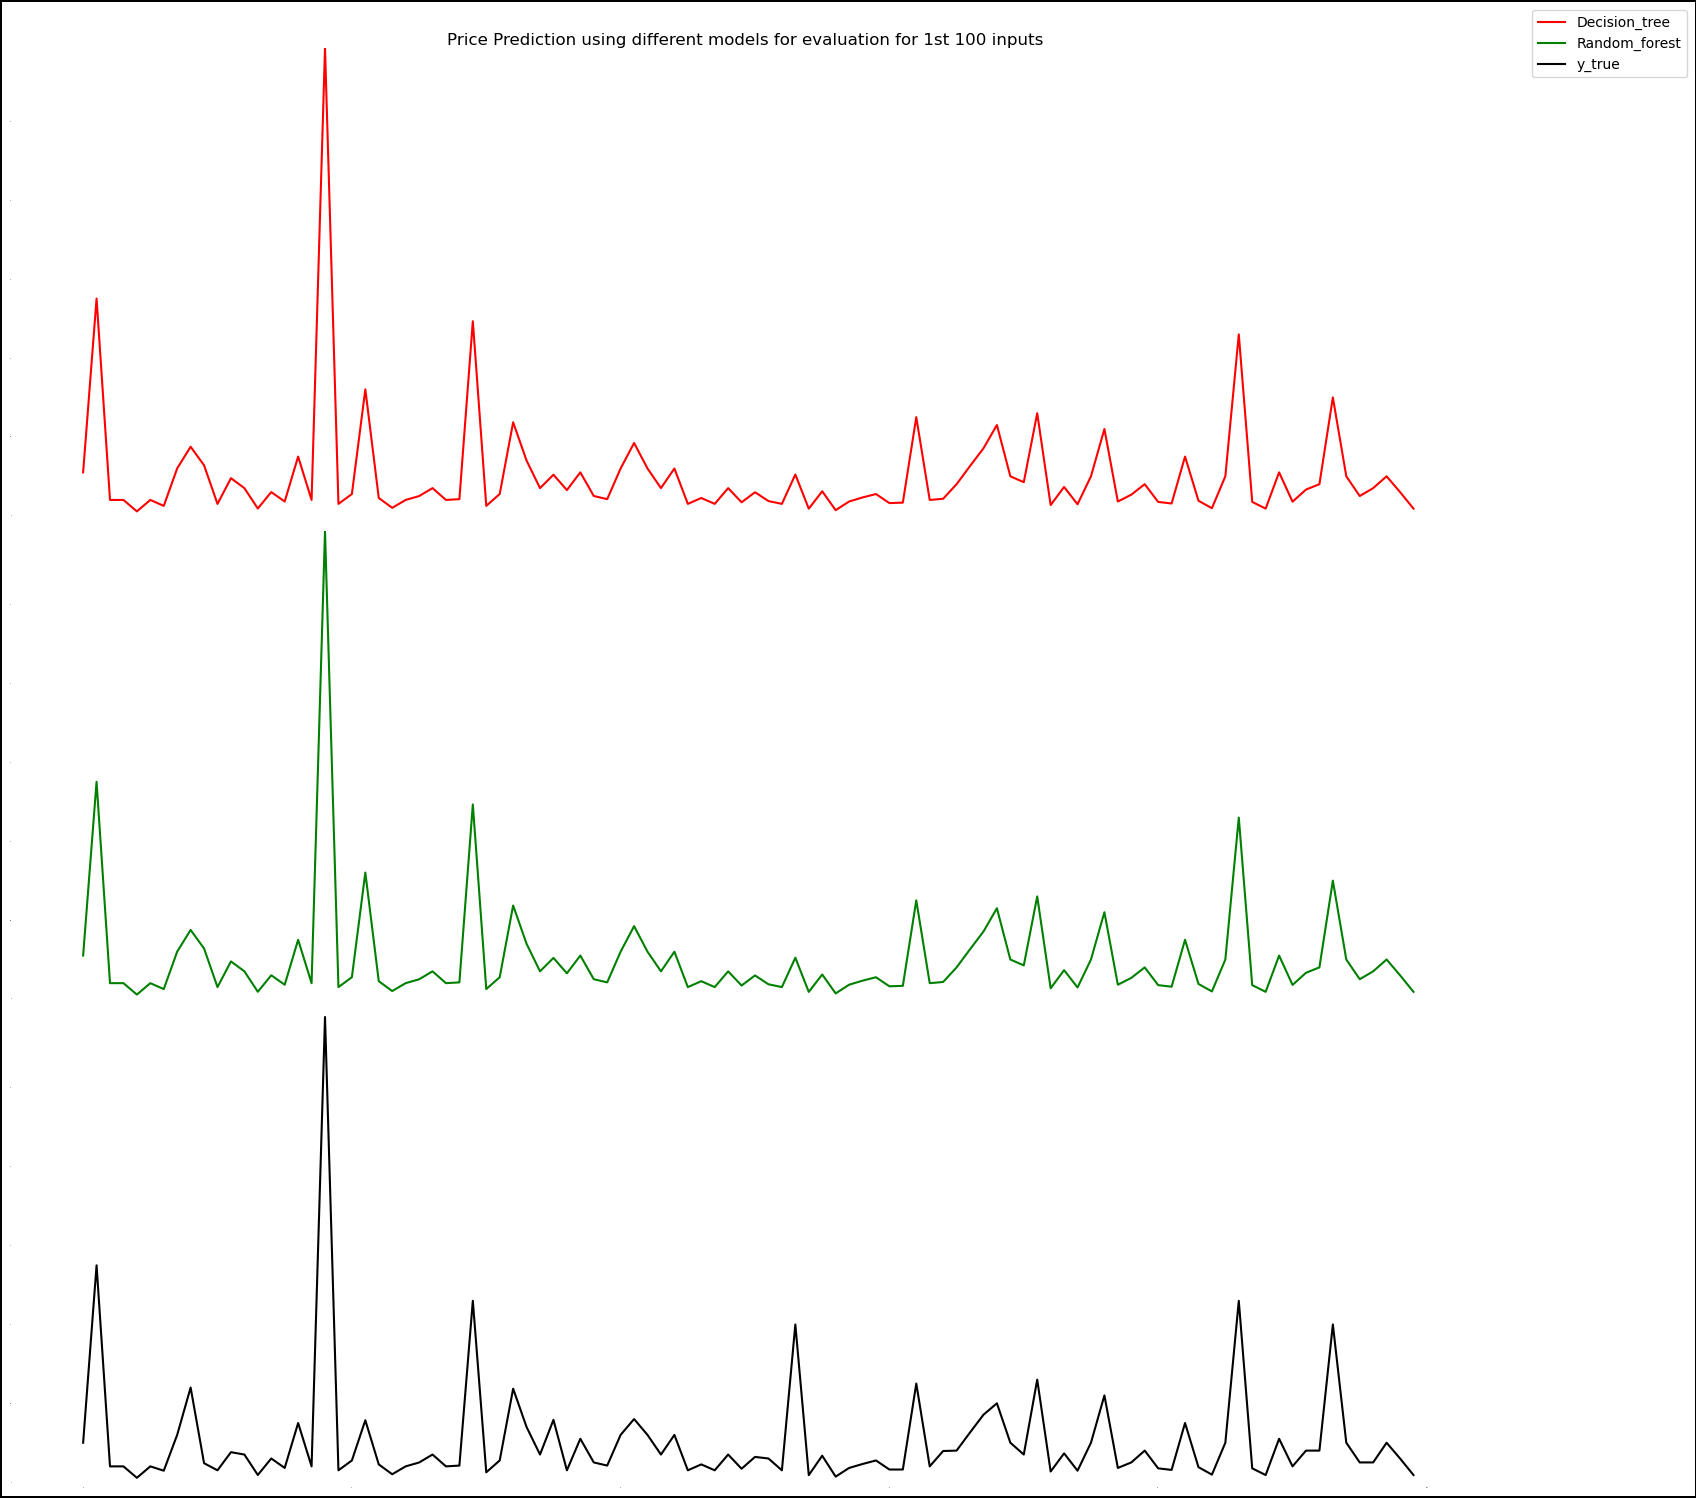

In [39]:
y_pred_hyperparamter_tuned_2 = y_pred_hyperparamter_tuned[:100]
y_val_100 = y_val[:100]
y_val_100 = y_val_100.reset_index(drop=True)
y_pred_hyperparamter_tuned_2["y_true"] = y_val_100

colors = ['red', 'green', "black"]

# Create subplots
fig, axs = plt.subplots(len(y_pred_hyperparamter_tuned_2.columns), 1, figsize=(15, 15), sharex=True, sharey=True)
# Initialize lists to collect handles and labels for the legend
handles = []
labels = []
max_value = y_pred_hyperparamter_tuned_2.max().max()

for i, (column, color) in enumerate(zip(y_pred_hyperparamter_tuned_2.columns, colors)):
    line, = axs[i].plot(y_pred_hyperparamter_tuned_2.index, y_pred_hyperparamter_tuned_2[column], color=color)
    axs[i].tick_params(axis='both', which='both', length=0, labelsize=0)
    axs[i].set_ylim(0, max_value) 
    handles.append(line)
    labels.append(column)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Create a single legend for all subplots and place it outside the borders
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 1))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1.5)
fig.suptitle("Price Prediction using different models for evaluation for 1st 100 inputs")

plt.subplots_adjust(right=0.85) 
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Predicted_values_stage_2_1st_100_inputs.png'))
plt.show()

In [ ]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32))

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Different combinations of loss functions and optimizers
loss_functions = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss()]
optimizers = [optim.SGD, optim.Adam, optim.RMSprop]

for loss_func in loss_functions:
    for opt in optimizers:
        # Create an instance of the model
        model = SimpleNN()

        # Define loss function and optimizer
        criterion = loss_func
        optimizer = opt(model.parameters(), lr=0.01)

        # Reset early stopping parameters for each combination
        patience = 5
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model_state = None

        # Training loop
        for epoch in range(500):
            # Forward pass
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validation loss
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor)
                val_predicted = val_outputs.detach().numpy()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f'Early stopping triggered at epoch {epoch+1}')
                    break

            if epoch % 100 == 0:
                print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # Load the best model state
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Evaluate the trained model on the validation set
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_predicted = val_outputs.numpy()
        val_rmse = np.sqrt(mean_squared_error(y_val_tensor.numpy(), val_predicted))
        val_r2 = r2_score(y_val_tensor.numpy(), val_predicted)
        print(f'Validation RMSE with {loss_func.__class__.__name__} and {opt.__name__}: {val_rmse:.4f}')
        print(f'Validation R2 Score with {loss_func.__class__.__name__} and {opt.__name__}: {val_r2:.4f}')

Epoch [1/1000], Loss: 72.3265, Val Loss: 68.4997
Epoch [101/1000], Loss: 41.0017, Val Loss: 41.8916
Epoch [201/1000], Loss: 40.8395, Val Loss: 41.7393
Epoch [301/1000], Loss: 40.6709, Val Loss: 41.5733
Epoch [401/1000], Loss: 40.5413, Val Loss: 41.4406
Validation RMSE with MSELoss and SGD: 6.4304
Validation R2 Score with MSELoss and SGD: 0.1062
Epoch [1/1000], Loss: 76.1239, Val Loss: 74.8807
Early stopping triggered at epoch 31
Validation RMSE with MSELoss and Adam: 6.5963
Validation R2 Score with MSELoss and Adam: 0.0595
Epoch [1/1000], Loss: 72.9329, Val Loss: 57.6822
Epoch [101/1000], Loss: 40.2542, Val Loss: 41.1240
Early stopping triggered at epoch 136
Validation RMSE with MSELoss and RMSprop: 6.4151
Validation R2 Score with MSELoss and RMSprop: 0.1105
Epoch [1/1000], Loss: 5.0296, Val Loss: 4.9800
Epoch [101/1000], Loss: 3.3818, Val Loss: 3.3901
Epoch [201/1000], Loss: 3.2818, Val Loss: 3.2939
Epoch [301/1000], Loss: 3.2467, Val Loss: 3.2600
Epoch [401/1000], Loss: 3.2320, Val L